In [4]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np

In [102]:
import json

with open('../data/partijen-metadata.json', 'r') as f:
     meta = json.load(f)

party_dict = {}
for party_data in meta['partijen']:
    party_id = party_data['lijst']
    party_name = party_data['naam'].encode('utf-8')
    party_dict["{:02d}".format(party_id)] = party_name
    
raw = pd.read_csv('../data/processed/dataframe.csv') 
raw['file'] = raw['file'].replace(to_replace=party_dict, regex=True).apply(lambda x: x.split('-')[1])
raw.rename(columns={'file': 'party'}, inplace=True)

party_labels = raw['party']
n_parties = len(party_labels)

def chunk_string(string, length):
    return [string[0+i:length+i] for i in range(0, len(string), length)]

df = raw['text'].apply(lambda x: pd.Series(chunk_string(x, length=600))).stack().reset_index()
df.rename(columns={0: 'text', 'level_0': 'party', 'level_1': 'snippet'}, inplace=True)

print "{:d} text snippets".format(len(df))
df.head()

4897 text snippets


,party,snippet,text
0,0,0,n e d n o b r e v n ee g n i v e l sa m e n ve...
1,0,1,twerp paul pollmann inhoudsopgave essay ee...
2,0,2,rismebestrijding privacy justitie en rechtstaa...
3,0,3,ing werk en gezin pensioenen werkende ouderen ...
4,0,4,iedereen publieke waarden centraal van marktw...


Probably lots of party-specific words in these snippets (e.g. title footers parsed from PDF), so we can only play with some naive multiclass classifiers before we fix this (e.g. Naive Bayes, kNN).

In [111]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
#from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline

from nltk.corpus import stopwords
from nltk.stem.snowball import DutchStemmer
from nltk import word_tokenize

stemmer = DutchStemmer()
def tokenize(text):
    """Converts text to tokens."""
    tokens = word_tokenize(text)
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

vectorizer = CountVectorizer(encoding='utf-8', decode_error='strict',
                 strip_accents=None, lowercase=True, preprocessor=None,
                 tokenizer=tokenize, stop_words=stopwords.words('dutch'),
                 ngram_range=(1, 2), analyzer='word', max_df=0.1, min_df=2, max_features=1000,
                 vocabulary=None, binary=False, dtype=np.int64)

# cross-validation
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=1)  # note that stratification doesnt work with native multiclass

# extract data from data frame
X = df['text'].values 
#y = np.array(pd.get_dummies(df['party']))  # format for OneVsRestClassifier
y = np.array(df['party'])

# baseline
baseline_estimator = make_pipeline(vectorizer, DummyClassifier(strategy='prior', random_state=1))

scores = cross_val_score(baseline_estimator, X, y, cv=cv)
print "Average baseline score: {:.4f} ".format(np.mean(scores))

# model
equal_priors = np.ones(n_parties) * 1. / n_parties
estimator = make_pipeline(vectorizer, MultinomialNB(class_prior=equal_priors))  # force equal priors for more fair predictions

scores = cross_val_score(estimator, X, y, cv=cv)
print "Average model score: {:.4f} ".format(np.mean(scores))

# fit on whole data set
estimator.fit(X, y)
estimator

Average baseline score: 0.1388 
Average model score: 0.5422 


Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<type 'numpy.int64'>, encoding='utf-8', input=u'content',
        lowercase=True, max_df=0.1, max_features=1000, min_df=2,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=...04348,  0.04348,
        0.04348,  0.04348,  0.04348,  0.04348,  0.04348]),
       fit_prior=True))])

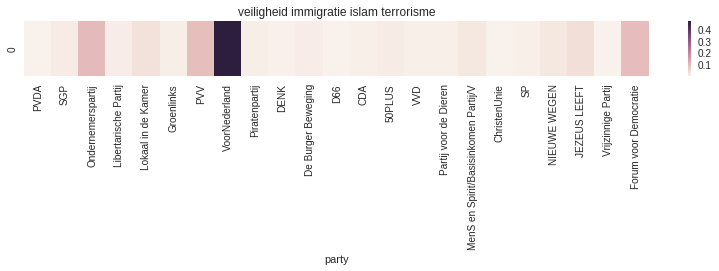

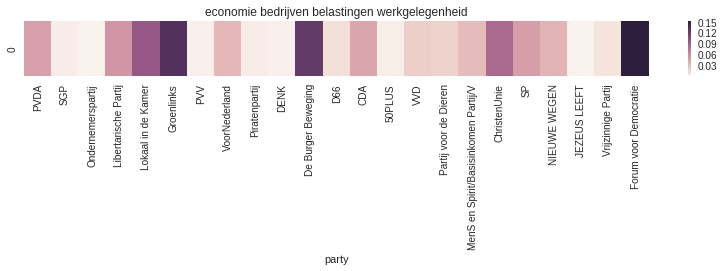

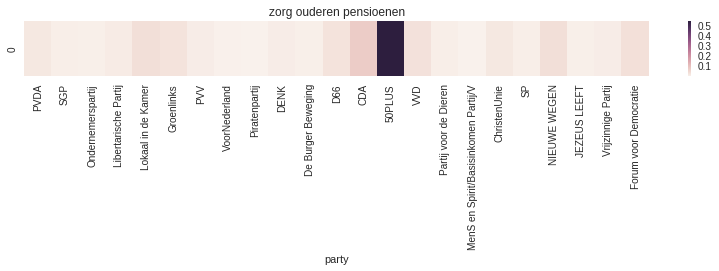

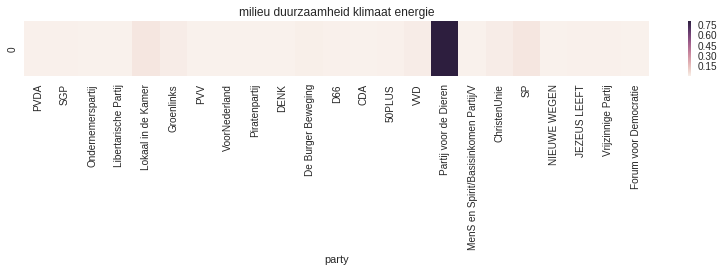

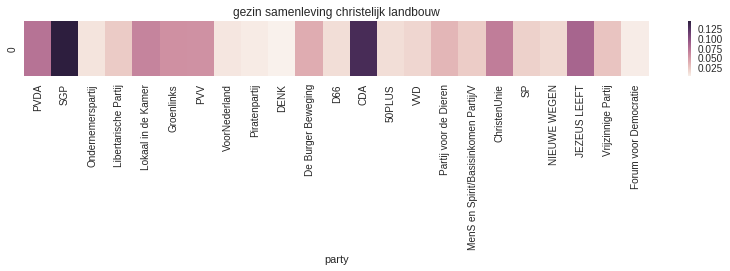

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_predictions(pred_proba, title=None):
    fig, ax = plt.subplots(figsize=(14,1))   
    results = pd.DataFrame(pred_proba, columns=[party_labels])
    sns.heatmap(results, ax=ax)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel('')
    
def classify_text(estimator, text, disp_text=True):
    pred_proba = estimator.predict_proba([text])
    plot_predictions(pred_proba, title=text)

texts = ['veiligheid immigratie islam terrorisme', 'economie bedrijven belastingen werkgelegenheid',
         'zorg ouderen pensioenen', 'milieu duurzaamheid klimaat energie', 'gezin samenleving christelijk landbouw']

for text in texts:
    classify_text(estimator, text)